In [95]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , recall_score ,  precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import seaborn as sns

## Data Preparation:

Lets prepare our data for modeling

In [96]:
# Read data

flight_details_janury_2019 = pd.read_csv('/content/Jan_2019_ontime.csv')

flight_details_janury_2019.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [54]:
# check the columns:
flight_details_janury_2019.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED',
       'DIVERTED', 'DISTANCE', 'Unnamed: 21'],
      dtype='object')

In [55]:
# check type of columns:
flight_details_janury_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           583985 non-null  int64  
 1   DAY_OF_WEEK            583985 non-null  int64  
 2   OP_UNIQUE_CARRIER      583985 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  583985 non-null  int64  
 4   OP_CARRIER             583985 non-null  object 
 5   TAIL_NUM               581442 non-null  object 
 6   OP_CARRIER_FL_NUM      583985 non-null  int64  
 7   ORIGIN_AIRPORT_ID      583985 non-null  int64  
 8   ORIGIN_AIRPORT_SEQ_ID  583985 non-null  int64  
 9   ORIGIN                 583985 non-null  object 
 10  DEST_AIRPORT_ID        583985 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    583985 non-null  int64  
 12  DEST                   583985 non-null  object 
 13  DEP_TIME               567633 non-null  float64
 14  DEP_DEL15              567630 non-nu

Lets understand what we are looking to predict:

We have dataset of flights from januray 2019 and we want to 

*   We have dataset of flights from januray 2019 and we want to 
predict if some flight will delayed or not.
*  In our dataset, we have 2 columns of delay: 1 column for departure delay [DEP_DEL15], and 1 column for arrivel delay [ARR_DEL15] 

*  We want to predict if someflight will delayed in any time - arrival or departure. So lets create new classifier, named under "delayed" with 2 result:

1.   Delayed - 1 the flight will delayListtem
2.   Delayed - 0 the flight will not delay



In [56]:
flight_details_janury_2019['DELAYED'] = (flight_details_janury_2019['ARR_DEL15'].astype(bool) | flight_details_janury_2019['DEP_DEL15'].astype(bool)).astype(int)

We want to remove the canceled and diverted flights, because we are looking for flights that succesfuly departed

In [57]:
print("The number of rows before deleted 'Cancelled' column and `DIVERTED` is " + str(flight_details_janury_2019.shape[0]) )

flight_details_janury_2019.drop(flight_details_janury_2019[flight_details_janury_2019.CANCELLED == 1].index, inplace=True)

flight_details_janury_2019.drop(flight_details_janury_2019[flight_details_janury_2019.DIVERTED == 1].index, inplace=True)

print("The number of rows after deleted 'Cancelled' column and `DIVERTED` is " + str(flight_details_janury_2019.shape[0]) )

The number of rows before deleted 'Cancelled' column and `DIVERTED` is 583985
The number of rows after deleted 'Cancelled' column and `DIVERTED` is 565963


Lets get rid of unuseful columns, that not impact on our results:


*   OP_CARRIER_AIRLINE_ID - The id of the airline , because we will use the name of airline , for correltions and plots , more clearly to understand ariline name code than the airline id , and after that we will convert the name to numeric value
*   TAIL_NUM - dosnt give us any information
*   OP_CARRIER_FL_NUM - dosnt give us any information
*   ORIGIN_AIRPORT_ID , 'ORIGIN_AIRPORT_ID' ,ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID' - we have instead the origin and destination airport ATA code , more clearly for understading in plots.
*   Unnamed: 21 - Unrelevant column
*   OP_CARRIER - same as OP_UNIQUE_CARRIER
*   DEP_DEL15 - We convert the DEP and ARR to DELAYED Column
*   ARR_DEL15 - We convert the DEP and ARR to DELAYED Column
*   CANCELED - We check only for delayed flight , so Canceled flight are dont relevant
*   DIVERTED - We check only for delayed flight , so Canceled flight are dont relevant





In [58]:
flight_details_janury_2019.drop(['OP_CARRIER_AIRLINE_ID','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','Unnamed: 21','OP_CARRIER','ARR_DEL15','DEP_DEL15','CANCELLED', 'DIVERTED'], axis='columns', inplace=True)

Lets check distribution of our target variable:

In [59]:
flight_details_janury_2019['DELAYED'].value_counts()

0    440724
1    125239
Name: DELAYED, dtype: int64

We can see that there are very highly difference between the rows with value 1 and 0 , so we should decrease our rows with value 0.

In [60]:
88# Split the data into positive and negative
pos = flight_details_janury_2019.loc[flight_details_janury_2019.DELAYED == 1]
neg = flight_details_janury_2019.loc[flight_details_janury_2019.DELAYED == 0]

# Merge the balanced data
data = pd.concat([pos, neg.sample(n = len(pos))], axis = 0)

# Shuffle the order of data
flight_details_janury_2019 = data.sample(n = len(data)).reset_index(drop = True)

In [61]:
flight_details_janury_2019['DELAYED'].value_counts()

0    125239
1    125239
Name: DELAYED, dtype: int64

Lets rename names if needed for more readble:

In [62]:
flight_details_janury_2019 = flight_details_janury_2019.rename(columns={"OP_UNIQUE_CARRIER": "AIRLINE_CODE"})

Check for some Null/Na values:

In [63]:
flight_details_janury_2019.isna().sum()

DAY_OF_MONTH    0
DAY_OF_WEEK     0
AIRLINE_CODE    0
ORIGIN          0
DEST            0
DEP_TIME        0
DEP_TIME_BLK    0
ARR_TIME        0
DISTANCE        0
DELAYED         0
dtype: int64

the data is clean , we dont have any null values.

**Summerize:**

In [66]:
print("The Data types is:")
flight_details_janury_2019.info()

The Data types is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250478 entries, 0 to 250477
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DAY_OF_MONTH  250478 non-null  int64  
 1   DAY_OF_WEEK   250478 non-null  int64  
 2   AIRLINE_CODE  250478 non-null  object 
 3   ORIGIN        250478 non-null  object 
 4   DEST          250478 non-null  object 
 5   DEP_TIME      250478 non-null  float64
 6   DEP_TIME_BLK  250478 non-null  object 
 7   ARR_TIME      250478 non-null  float64
 8   DISTANCE      250478 non-null  float64
 9   DELAYED       250478 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 19.1+ MB


In [67]:
print("Our final data include: " + str(flight_details_janury_2019.shape[0]) + " Rows and " + str(flight_details_janury_2019.shape[1]) + " Columns" )

Our final data include: 250478 Rows and 10 Columns


In [68]:

 flight_details_janury_2019.head()

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE_CODE,ORIGIN,DEST,DEP_TIME,DEP_TIME_BLK,ARR_TIME,DISTANCE,DELAYED
0,23,3,WN,ORF,MDW,1612.0,1600-1659,1714.0,704.0,0
1,13,7,OO,LAX,SLC,2039.0,2000-2059,2313.0,590.0,0
2,31,4,F9,LAS,SAT,1608.0,1600-1659,2048.0,1069.0,0
3,21,1,EV,DCA,CLE,2015.0,1700-1759,2137.0,310.0,1
4,15,2,MQ,FAR,ORD,1606.0,1500-1559,1753.0,557.0,1


Final Data Format:

After we carefully analyzing each data points, This is the final data:

 DAY_OF_MONTH - Day of Month

 DAY_OF_WEEK - Day of Week

AIRLINE_CODE - Airline Carrier Code

ORIGIN - Origin airport location

DEST - Destination airport location

DEP_TIME - Actual Departure Time (local time: hhmm)

DEP_TIME_BLK - Time Block Departure (hhmm-hhmm)

ARR_TIME - Actual Arrivel Time (local time: hhmm)

DISTANCE - Distance between airports (miles)

DELAYED - Classifier - 1 If flight delayed, else - 0


## Exploratory Data Analysis

Histograms:


array([[<Axes: title={'center': 'DAY_OF_MONTH'}>,
        <Axes: title={'center': 'DAY_OF_WEEK'}>],
       [<Axes: title={'center': 'DEP_TIME'}>,
        <Axes: title={'center': 'ARR_TIME'}>],
       [<Axes: title={'center': 'DISTANCE'}>,
        <Axes: title={'center': 'DELAYED'}>]], dtype=object)

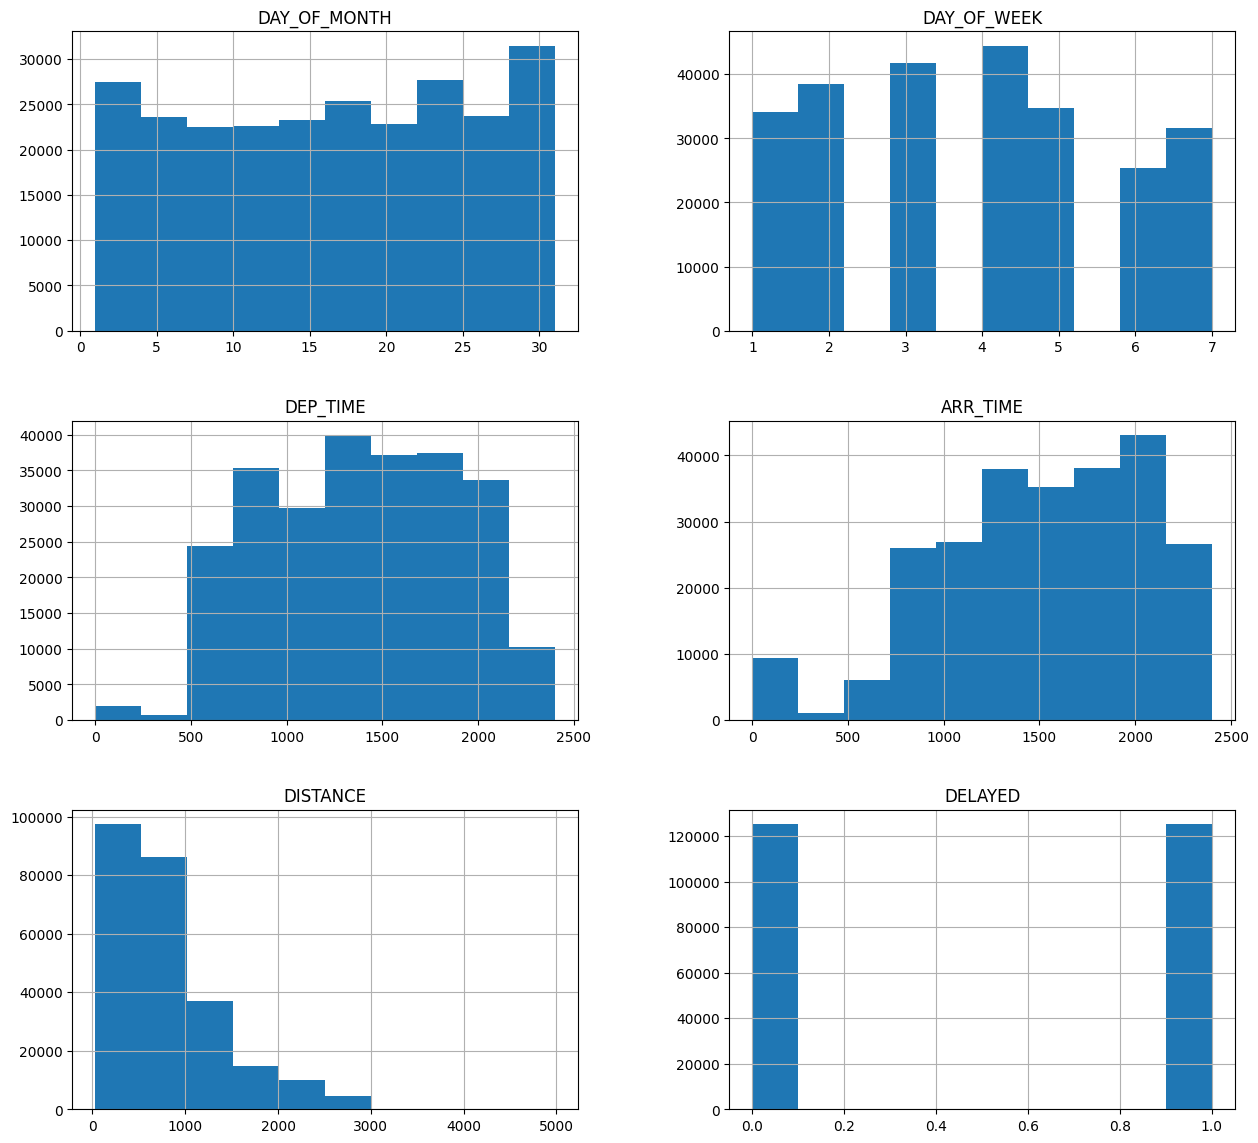

In [69]:
flight_details_janury_2019.hist(figsize= (15, 14))

In [70]:
flight_details_janury_2019.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,DELAYED
count,250478.000000,250478.000000,250478.000000,250478.000000,250478.000000,250478.000000
mean,15.980230,3.838217,1385.605530,1512.554723,810.344713,0.500000
std,9.032206,1.912918,496.996603,548.958248,593.550555,0.500001
min,1.000000,1.000000,1.000000,1.000000,31.000000,0.000000
25%,8.000000,2.000000,1001.000000,1130.000000,370.000000,0.000000
50%,16.000000,4.000000,1415.000000,1553.000000,651.000000,0.500000
75%,24.000000,5.000000,1808.000000,1947.000000,1050.000000,1.000000
max,31.000000,7.000000,2400.000000,2400.000000,4983.000000,1.000000


**Lets look for some corelations between the features and our classifier for better understanding, and learn a more about our features.**

First Lets see if there some dfference between airline companies delay, due to result we can understand if there problem with spesific company.

<Axes: xlabel='AIRLINE_CODE'>

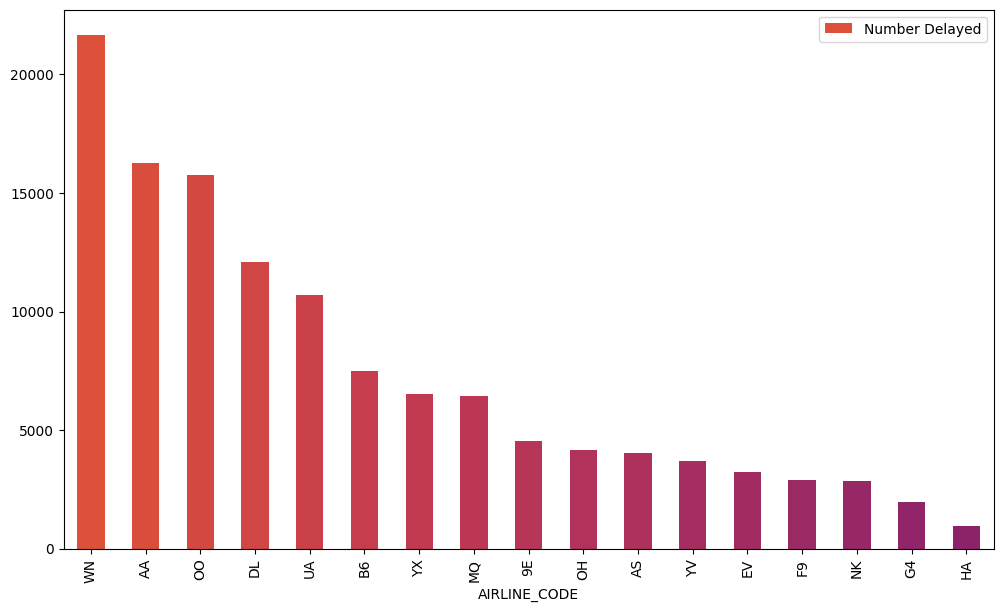

In [71]:
# Count delayes by company
count_delayed=flight_details_janury_2019.groupby('AIRLINE_CODE')['DELAYED'].apply(lambda x: (x==1).sum()).reset_index(name='Number Delayed')

color = cm.inferno_r(np.linspace(.4, .8, 30))

count_delayed= count_delayed.sort_values("Number Delayed" , ascending=[False])
count_delayed.plot.bar(x='AIRLINE_CODE', y='Number Delayed', color=color , figsize=(12,7))

Now lets see if there any corellation between the distance and delays:

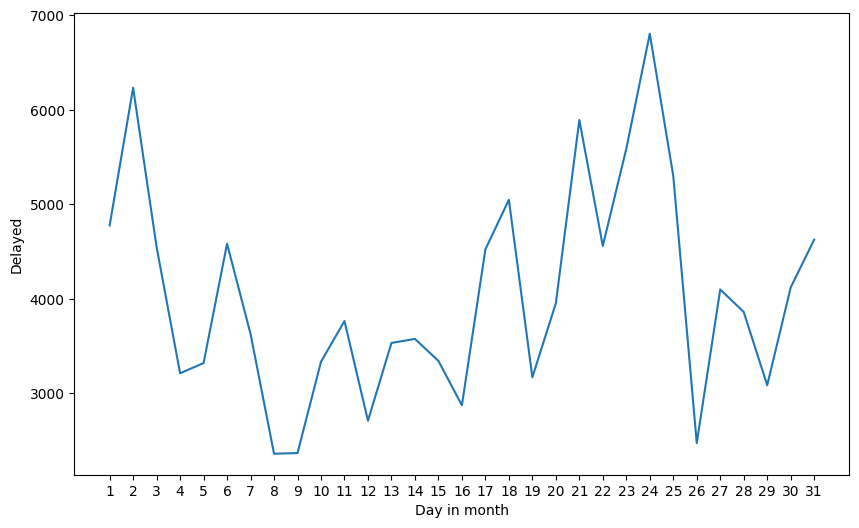

In [72]:
monthly_days_delayed=flight_details_janury_2019.groupby('DAY_OF_MONTH')['DELAYED'].apply(lambda x: (x==1).sum()).reset_index(name='Number Delayed')
plt.figure(figsize=(10, 6))
plt.xticks(monthly_days_delayed['DAY_OF_MONTH'])
plt.plot(monthly_days_delayed['DAY_OF_MONTH'],monthly_days_delayed['Number Delayed'])
plt.ylabel('Delayed')
plt.xlabel('Day in month')
plt.show()


Avergae Distance with delay: 828.707846597306 mile
Avergae Distance without delay: 791.9815792205303 mile


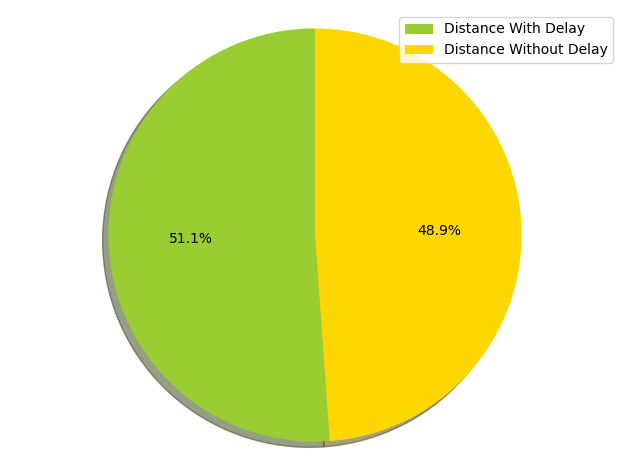

In [73]:
#Calculate the precent of delays with average distance:
avg_distance_delay = flight_details_janury_2019[flight_details_janury_2019['DELAYED'] == 1]['DISTANCE'].values.mean()
#Calculate the precent of delays without average distance:
avg_distance_without_delay = flight_details_janury_2019[flight_details_janury_2019['DELAYED'] == 0]['DISTANCE'].values.mean()

print("Avergae Distance with delay: " + str(avg_distance_delay) + " mile")
print("Avergae Distance without delay: "+ str(avg_distance_without_delay) +" mile")

labels = ['Distance With Delay', 'Distance Without Delay']
sizes = [avg_distance_delay,avg_distance_without_delay]
colors = ['yellowgreen', 'gold']
texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

Let's see in wich day are the higher number of delays:

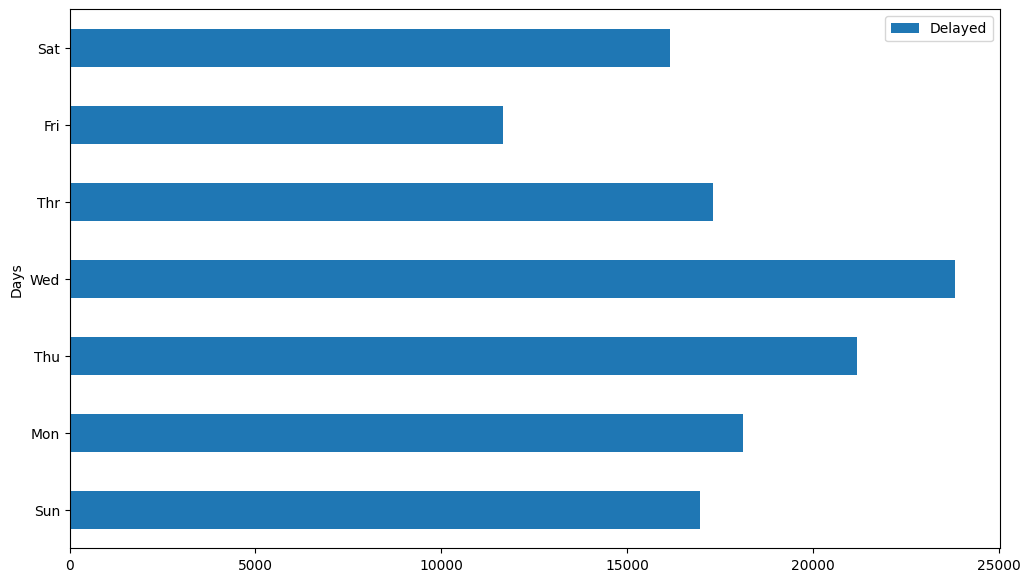

In [74]:
# Create the data for the days adays_values
days_values = flight_details_janury_2019.groupby('DAY_OF_WEEK')['DELAYED'].apply(lambda x: (x==1).sum()).reset_index(name='Number Delayed')
days_values.sort_values("DAY_OF_WEEK" )

days_values['DAY_OF_WEEK'] = days_values['DAY_OF_WEEK'].map({1: 'Sun', 2: 'Mon', 3:'Thu',4:'Wed',5:'Thr',6:'Fri',7:'Sat'})

df = pd.DataFrame({'Days':days_values['DAY_OF_WEEK'],'Delayed':days_values['Number Delayed']})
ax = df.plot.barh(x='Days',y='Delayed',figsize=(12,7))


We have to encode our categorial Variabels before we move to modeling:

OP_UNIQUE_CARRIER

ORIGIN

DEST

DEST_TIME_BLK

In [75]:
def encode_categories(features):
    lb_make = LabelEncoder()
    for i in range(len(features)):
        flight_details_janury_2019[features[i]] = lb_make.fit_transform(flight_details_janury_2019[features[i]])

In [76]:
encode_categories(['AIRLINE_CODE','ORIGIN','DEST','DEP_TIME_BLK',])
flight_details_janury_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250478 entries, 0 to 250477
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DAY_OF_MONTH  250478 non-null  int64  
 1   DAY_OF_WEEK   250478 non-null  int64  
 2   AIRLINE_CODE  250478 non-null  int64  
 3   ORIGIN        250478 non-null  int64  
 4   DEST          250478 non-null  int64  
 5   DEP_TIME      250478 non-null  float64
 6   DEP_TIME_BLK  250478 non-null  int64  
 7   ARR_TIME      250478 non-null  float64
 8   DISTANCE      250478 non-null  float64
 9   DELAYED       250478 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 19.1 MB


Collerations between our features:

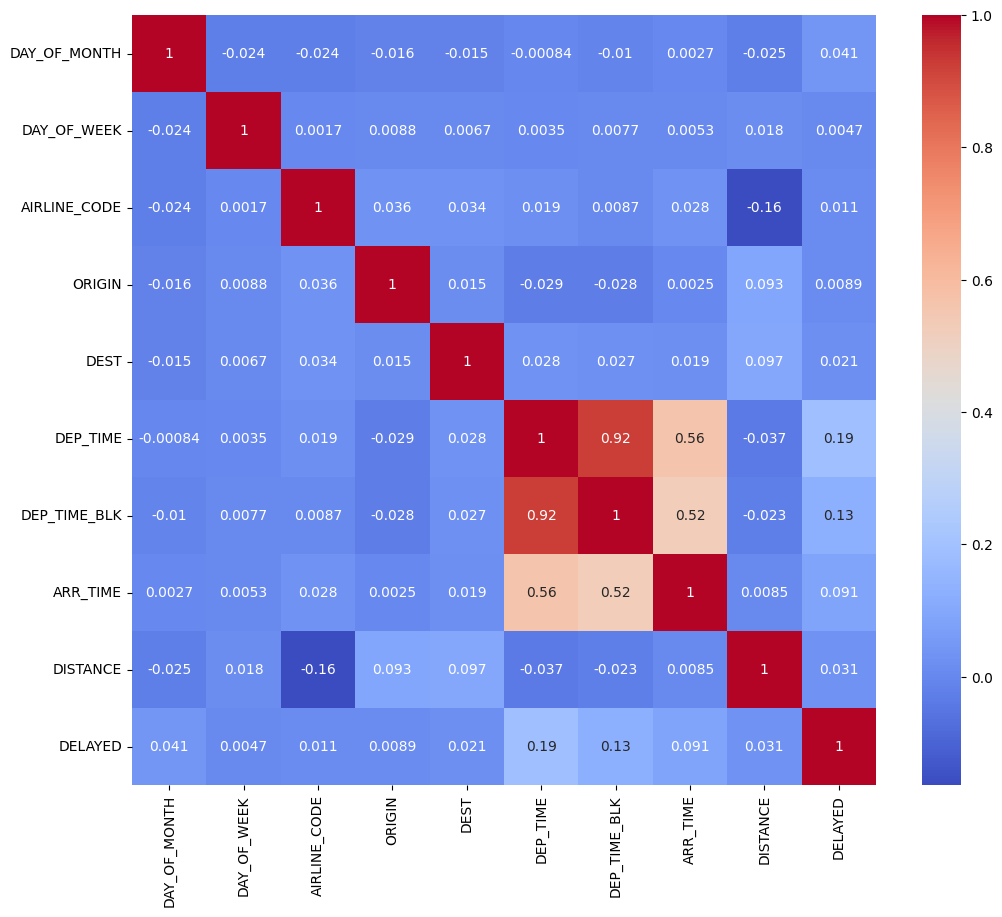

In [77]:
plt.figure(figsize = (12, 10))
sns.heatmap(flight_details_janury_2019.corr(), annot = True, cmap = 'coolwarm')
plt.show()

**Modeling**

Lets first create Test set and Train set:

In [78]:
# Create test and train:
feature_names = ['DAY_OF_MONTH','DAY_OF_WEEK','AIRLINE_CODE','ORIGIN','DEST','DEP_TIME','DEP_TIME_BLK','ARR_TIME','DISTANCE']
X =  flight_details_janury_2019[feature_names].values
y =  flight_details_janury_2019['DELAYED'].values

In [79]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [80]:
rf = RandomForestClassifier(n_estimators = 350,max_depth=14,min_samples_leaf=15,min_samples_split=5, n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=15, min_samples_split=5,
                       n_estimators=350, n_jobs=-1)

In [81]:
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

GradientBoostingClassifier()

In [82]:
dt = DecisionTreeClassifier(max_depth=15)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=15)

In [83]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)

AdaBoostClassifier()

**Evaluate**

Evaluating of accuarcy of our models

In [84]:
# Acurracy of each model
def get_accuracy(model):
        pred = model[0].predict(X_test)
        check_overfitting(model)
        return accuracy_score(y_test, pred)

In [85]:
def check_overfitting(model):
        pred = model[0].predict(X_test)
        over_fit_check_pred = model[0].predict(X_train)
        print('Checking '+ model[1] + ' Overffiting:')
        print('Train Accuracy ' + str(accuracy_score(y_train, over_fit_check_pred)))
        print('Test Accuracy ' + str(accuracy_score(y_test, pred)))
        print('--------------------------')

In [86]:
# Plot the confusion matrix for each model:
def get_confusion_matrix(model):
    from sklearn.metrics import plot_confusion_matrix
    class_names=['Delay-False','Delay-true']
    disp = plot_confusion_matrix(model[0], X_test, y_test,
                                     display_labels=class_names, values_format='d',
                                     cmap=model[2])
    precision = precision_score(y_test, model[0].predict(X_test), average='binary')
    recall = recall_score(y_test, model[0].predict(X_test), average='binary')
    print('Avg Precision:' +  str(precision))
    print('Avg Recall:' + str(recall))
    
    disp.ax_.set_title(model[1])
    plt.show()

In [87]:
### Save the accuracy
models = [[rf,'Random Forest',plt.cm.Blues],[gb,'Gradient Boosting',plt.cm.Greens],[dt,'Decision Tree',plt.cm.Reds],[ab,'AdaBoost',plt.cm.Oranges]]
accuracy = []
for model in models:
    accuracy.append(get_accuracy(model))

Checking Random Forest Overffiting:
Train Accuracy 0.8254987623621203
Test Accuracy 0.7972692430533376
--------------------------
Checking Gradient Boosting Overffiting:
Train Accuracy 0.7781890563153753
Test Accuracy 0.7760300223570744
--------------------------
Checking Decision Tree Overffiting:
Train Accuracy 0.8289607263850708
Test Accuracy 0.7862370914510806
--------------------------
Checking AdaBoost Overffiting:
Train Accuracy 0.661896722826149
Test Accuracy 0.6573379112104759
--------------------------


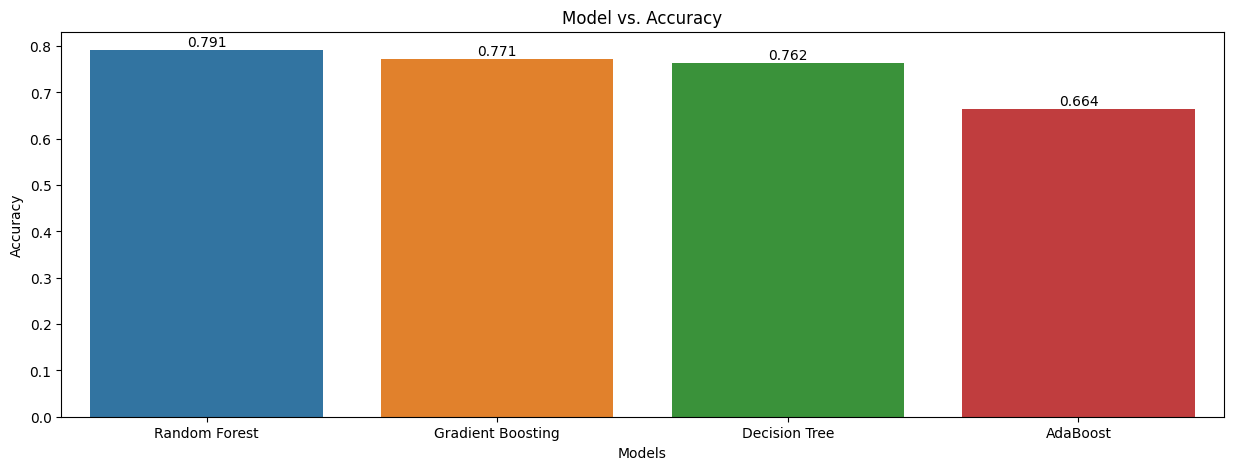

In [48]:
plt.figure(figsize=(15,5))
model_names = ['Random Forest','Gradient Boosting','Decision Tree','AdaBoost']
ax = sns.barplot(x = model_names, y =accuracy)

accuracy_dic = dict(zip(model_names, accuracy))

for p, value in zip(ax.patches, list(accuracy_dic.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.show()

In [49]:
print(classification_report(y_test, rf.predict(X_test), target_names=['Delayed','Not Delayed']))

              precision    recall  f1-score   support

     Delayed       0.77      0.83      0.80     29598
 Not Delayed       0.82      0.75      0.78     29885

    accuracy                           0.79     59483
   macro avg       0.79      0.79      0.79     59483
weighted avg       0.79      0.79      0.79     59483



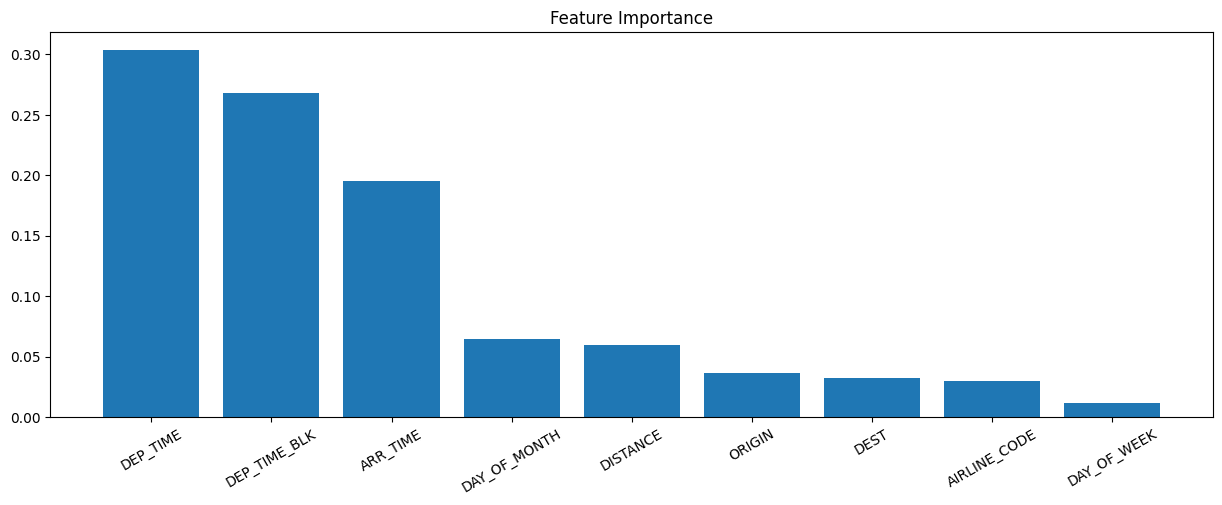

In [50]:
importances = rf.feature_importances_
features = list(flight_details_janury_2019.columns)
indices = np.argsort(importances)[::-1]

names = [features[i] for i in indices]

plt.figure(figsize=(15,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=30, fontsize = 10)
plt.title("Feature Importance")
plt.show()

We see that Random Forest give us the best accuracy. Lets try to change our params for Random forset, and maybe we will get better result.

**Hyperparameter tuning for RandomForest**

the optimization takes 20 minutes. for avoid long run time ,you can see the code and the result in report

Test again the model after we did some optimization and find good parameters:

In [51]:
# Save the older accur:
rf_old_accur = accuracy[0]

rf = RandomForestClassifier(n_estimators=200, min_samples_split=5, max_features='sqrt', max_depth=45)
rf.fit(X_train,y_train)

pred = rf.predict(X_test)
rf_new_accur = accuracy_score(y_test, pred)

print("The Accuracy of RandomForest Model before tuning: " + str(rf_old_accur))
print("The Accuracy of RandomForest Model after tuning: " + str(rf_new_accur))

print("Increase of : " + str(100-((rf_old_accur * 100 ) / rf_new_accur ))+' %')

The Accuracy of RandomForest Model before tuning: 0.7913689625607316
The Accuracy of RandomForest Model after tuning: 0.831968797807777
Increase of : 4.87997090203686 %
